## Generation Expansion Planning (GEP) Formulation

The following sections describe a simple GEP formulation that incorporates uncertainty in renewable energy by using stochastic scenarios for a two-stage problem.

### Indices

| **Name** | **Description**                   |
|----------|-----------------------------------|
| $p$      | time periods                      |
| $g$      | generation technologies           |
| $r(g)$   | subset of renewable techonologies |
| $sc$     | scenarios                         |

### Parameters

| **Name**   | **Domains** | **Description**                                             |
|------------|-------------|-------------------------------------------------------------|
| $pVOLL   $ |             | Value of Lost Load [\$/MWh]                                 |
| $pWeight $ |             | Representative period weight [hours]                        |
| $pInvCost$ | $g$         | Investment cost [\$/MW]                                     |
| $pVarCost$ | $g$         | Variable production cost [\$/MWh]                           |
| $pUnitCap$ | $g$         | Capacity per each invested unit [MW/unit]                   |
| $pRenProf$ | $r,p,sc$    | Renewable profile (e.g., load factor) [p.u.]                |
| $pDemand $ | $p$         | Demand [MW]                                                 |
| $pScProb $ | $sc$        | Scenario probability [p.u.]                                 |

### Variables

| **Name**    | **Domains** | **Description**              |
|-------------|-------------|------------------------------|
| $vTotCost $ |             | Total system cost [\$]       |
| $vInvCost $ |             | Total investment cost [\$]   |
| $vOpeCost $ |             | Total operating cost [\$]    |
| $vGenInv  $ | $g$         | Generation investment [1..N] |
| $vGenProd $ | $g,p,sc$    | Generation production [MW]   |
| $vLossLoad$ | $p,sc$      | Loss of load [MW]            |

### Equations

| **Name**    | **Domains** | **Description**                    |
|-------------|-------------|------------------------------------|
| $eObjFun $  |             | Total system cost [\$]             |
| $eInvCost$  |             | Total investment cost [\$]         |
| $eOpeCost$  |             | Total operating cost [\$]          |
| $eBalance$  | $p,sc$      | Power system balance [MWh]         |
| $eMaxProd$  | $g,p,sc$    | Maximum generation production [MW] |
| $eRenProd$  | $r,p,sc$    | Maximum renewable production [MW]  |

#### *eObjFun*

$$
\displaystyle{\min{vTotCost = vInvCost + vOpeCost}}
$$

#### *eInvCost*

$$
vInvCost = \displaystyle \sum_{g}(pInvCost_{g} \cdot pUnitCap_{g} \cdot vGenInv_{g})
$$

#### *eOpeCost*

$$
vOpeCost = pWeight \cdot {\left(\displaystyle \sum_{sc}pScProb_{sc}\cdot{\left(\sum_{g,p}pVarCost_{g} \cdot vGenProd_{g,p,sc} + \sum_{p,sc}pVOLL \cdot vLossLoad_{p,sc}\right)}\right)}
$$

#### *eBalance*

$$
\displaystyle \sum_{g}vGenProd_{g,p,sc} + vLossLoad_{p,sc} = pDemand_{p} \quad \forall{p,sc}
$$

#### *eMaxProd*

$$
vGenProd_{g,p,sc} \leq pUnitCap_{g} \cdot vGenInv_{g} \quad \forall{g,p,sc}
$$

#### *eRenProd*

$$
vGenProd_{r,p,sc} \leq pRenProf_{r,p,sc} \cdot pUnitCap_{r} \cdot vGenInv_{r} \quad \forall{r,p,sc}
$$

#### *Bounds*

$vGenProd_{g,p,sc}\geq 0 ~ \forall g, p, sc $

$vLossLoad_{p,sc}\geq 0 ~ \forall p, sc $

$vGenInv_{g} \in \mathbb{Z}^{+} ~ \forall g $


In [1]:
# Packages
using JuMP
using HiGHS
using CSV
using DataFrames
using Plots
using StatsPlots
using Printf

In [2]:
# include the helper functions
include("functions-to-import-data.jl");
include("functions-to-export-data.jl");
include("functions-to-plot-results.jl");

In [3]:
# include the file with the functions for the stochastic GEP model
include("Stochastic-GEP-two-stage-Benders.jl");

In [4]:
# Folders names
input_folder  = joinpath(@__DIR__, "inputs/two-stage-3sc");
output_folder = joinpath(@__DIR__, "outputs/two-stage-Benders-3sc");

In [5]:
# read the data
sets, params = read_two_stage_data(input_folder);

In [6]:
first_stage_model = create_first_stage_model(sets, params)

A JuMP Model
Minimization problem with:
Variables: 5
Objective function type: AffExpr
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 5 constraints
`VariableRef`-in-`MathOptInterface.Integer`: 4 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: v_investment, v_theta

In [7]:
# Benders decomposition algorithm

# Define constants
MAXIMUM_ITERATIONS = 100       # maximum number of iterations
ABSOLUTE_OPTIMALITY_GAP = 1e-6 # gap between lower and upper bounds to stop the algorithm

# Define outputs
df_Benders_interations = DataFrame(;
    iteration = Int[],
    lower_bound = Float64[],
    upper_bound = Float64[],
    gap = Float64[],
)

df_investment_per_iteration = DataFrame(;
    iteration = Int[],
    generator = String[],
    investment = Float64[],
)

# Start Benders' Decomposition
upper_bound = Inf
println("Iteration  Lower Bound  Upper Bound          Gap")
for iteration in 1:MAXIMUM_ITERATIONS
    optimize!(first_stage_model)
    @assert is_solved_and_feasible(first_stage_model)
    lower_bound  = objective_value(first_stage_model)
    p_investment = value.(first_stage_model[:v_investment])
    subproblem   = create_and_solve_subproblem(sets, params, p_investment)
    upper_bound  = minimum([
        upper_bound,
        objective_value(first_stage_model) - value.(first_stage_model[:v_theta]) +
        objective_value(subproblem),
    ])
    gap = (upper_bound - lower_bound) / upper_bound
    push!(df_Benders_interations, (iteration, lower_bound, upper_bound, gap))
    print_iteration(iteration, lower_bound, upper_bound, gap)
    
    if gap < ABSOLUTE_OPTIMALITY_GAP
        println("Terminating with the optimal solution")
        break
    end
    add_cut(first_stage_model, subproblem, sets, params, p_investment, iteration)

    for g in sets[:G]
        push!(df_investment_per_iteration, (iteration, g, p_investment[g]))
    end    
end

Iteration  Lower Bound  Upper Bound          Gap
        1  -1.0000e+03   1.5030e+06   1.0007e+00
        2   3.9000e+04   6.2448e+05   9.3755e-01
        3   1.3400e+05   5.3219e+05   7.4821e-01
        4   1.4421e+05   4.6402e+05   6.8921e-01
        5   1.6171e+05   2.9907e+05   4.5928e-01
        6   1.9000e+05   2.8280e+05   3.2816e-01
        7   2.1981e+05   2.8280e+05   2.2274e-01
        8   2.3240e+05   2.8280e+05   1.7823e-01
        9   2.5000e+05   2.8280e+05   1.1598e-01
       10   2.5023e+05   2.8280e+05   1.1517e-01
       11   2.5702e+05   2.8280e+05   9.1156e-02
       12   2.5770e+05   2.7801e+05   7.3040e-02
       13   2.6097e+05   2.7801e+05   6.1263e-02
       14   2.6252e+05   2.7459e+05   4.3957e-02
       15   2.6354e+05   2.7459e+05   4.0265e-02
       16   2.6440e+05   2.7257e+05   2.9993e-02
       17   2.6561e+05   2.7257e+05   2.5541e-02
       18   2.6607e+05   2.7054e+05   1.6518e-02
       19   2.6681e+05   2.7054e+05   1.3780e-02
       20   2.6695e+

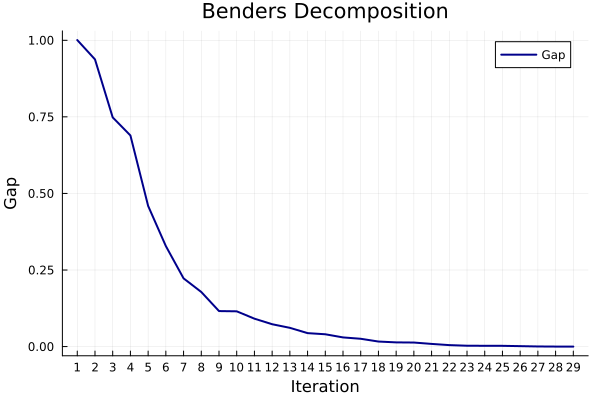

In [8]:
#plotly()
plot_benders_gap(df_Benders_interations)

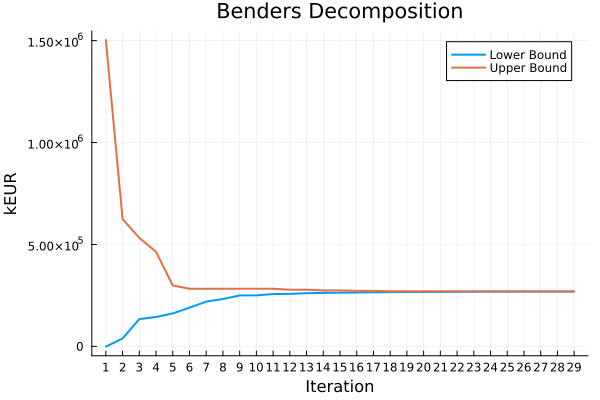

In [9]:
plot_benders_bounds(df_Benders_interations)

In [10]:
optimize!(first_stage_model)
@assert is_solved_and_feasible(first_stage_model)
v_investment_optimal = value.(first_stage_model[:v_investment])

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, String7["ocgt", "ccgt", "wind", "solar"]
And data, a 4-element Vector{Float64}:
  0.0
  2.0
 35.0
 45.0

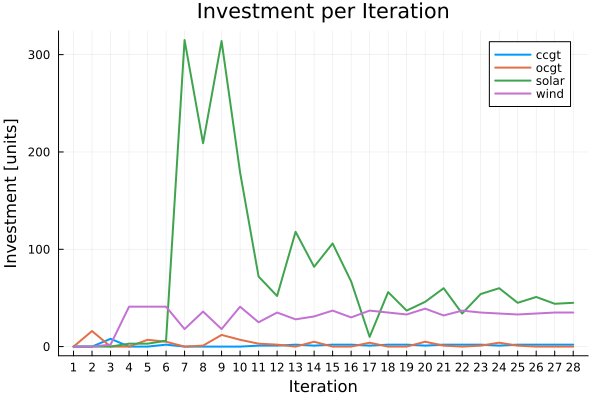

In [11]:
plot_investment_per_iteration(df_investment_per_iteration)

In [12]:
subproblem = create_and_solve_subproblem(sets, params, v_investment_optimal)

A JuMP Model
Minimization problem with:
Variables: 360
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 72 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 288 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 360 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 72 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: c_balance, c_max_prod, v_ens, v_production

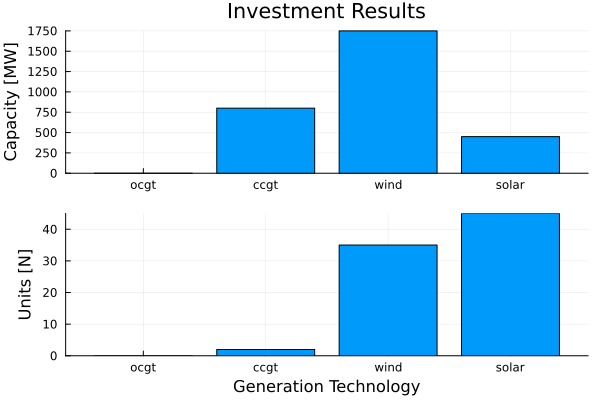

In [13]:
plot_two_stage_investment(first_stage_model, sets, params)

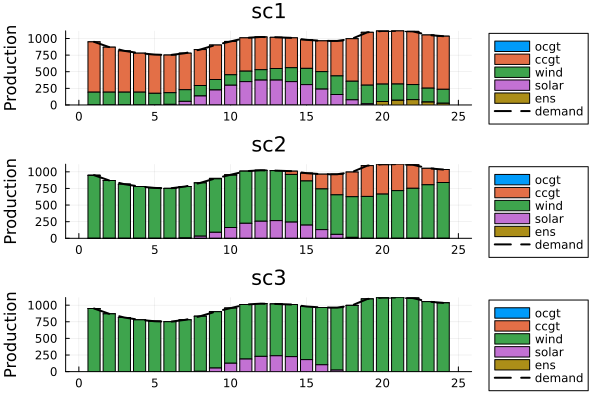

In [14]:
plot_two_stage_production(subproblem, params)

In [15]:
save_results_benders_first_stage_to_csv(output_folder, first_stage_model)
save_results_benders_subproblem_to_csv(output_folder, subproblem)

In [16]:
write_to_file(first_stage_model, "first_stage_model.lp")